# Quanvolutional Neural Networks
Quanvolutional Neural Networks or QNNs in short are part of the class of hybrid quantum-classical models and are used for image processing. A 'quanvolution' layer - which is implemented using a quantum circuit(device) - is first applied to the images, then a standard CNN framework is applied. The quantum circuit used is a random circuit, and the data of the images are encoded into the qubits using rotation oprators. Outputs are received from the circuit in the form of the expectation value of an observable(in particular the Pauli-$Z$) and form the feature maps.

The MNIST dataset is used as the input data and the CNN framework is a very simple(just one layer) neural network implemented in tensorflow.
Observations:
The extra quanvolutional layer doesn't do that well over the classical counterpart, it's just a tiny bit better but it is expected to do better over larger sets. The quanvolution operation takes a huge amount of time, though(about 3 images per second).


In [152]:
import pennylane as qml
from pennylane.devices.default_qubit import DefaultQubit
import tensorflow as tf
from tensorflow import keras
import pennylane.numpy as np
from matplotlib import pyplot as plt
from time import time

In [153]:
dev = DefaultQubit(wires=4) # dev is an instance of a DefaultQubit object.

# Main hyperparameters of the model
n_epochs = 15
n_train = 500
n_test = 150
n_rlayers = 1 # The number of layers(a bunch of gates) in the random circuit.
quantum_preprocessing = True # is one layer of Quanvolution used before the classical circuit.
np.random.seed(0)
rparams = np.random.uniform(low=0, high=2*np.pi, size=(n_rlayers, 4)) # four random (but fixed throughout the code) params for the q.ckt of each rlayer.
tf.random.set_seed(0)

In [154]:
# load mnist dataset. Same as Week4/mnist.ipynb, only change is we take only a subset of the data here, not full thing.

# use the MNIST black&white handwriting dataset already present in keras
mnist = keras.datasets.mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data() # capital letters to indicate a vectorized version of the whole training data(the X in logistic regression)

# shrink data to the size we chose.
X_train = X_train[:n_train]; y_train = y_train[:n_train]
X_test = X_test[:n_test]; y_test = y_test[:n_test]

# normalize the pixel values to be in [0, 1]
X_train = X_train/255; X_test = X_test/255 

# what does this do?
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

# recast the n_train x 28 x 28 numpy array X_train into a n_train x 28 x 28 x 1 numpy array. Why? Convolution expects a 4d array(one dimension for color).
X_train = X_train.reshape(*(X_train.shape), 1)
X_test = X_test.reshape(*(X_test.shape), 1)
print("Loaded.")

Loaded.


### The Quanvolution Circuit.
We now build the circuit that performs the quanvolution. This is not, strictly speaking, a convolution operation, rather a quantum circuit encoded with the image values is passed through a random(but constant throughout) quantum circuit and then an output(the result of the quanvolution) is returned(the output can be an expectation value or a measurement outcome - something to do with measurement of the final state).

In this example, the encoding is done as $$f: x \in [0, 1] \rightarrow \cos(\frac{\pi x}{2})|0\rangle + \sin(\frac{\pi x}{2})|0\rangle = R_y(\pi x)|0\rangle \text{  - a very neat representation indeed!}$$

The decoding is fairly simple - Each qubit returns the expectation value of the observable Pauli-$Z$.
Note that each qubit acts as one filter and so we have four filters as output, hence the shape of the output tensor is n_train x 14 x 14 x 4(stride = 2 so 14 x 14, but four channels(feature maps)).

In [155]:
@qml.qnode(dev)
def circuit(params):
    # encode
    for i in range(4): qml.RY(np.pi * params[i], i) # the initial state is |0\rangle, note.

    # pass this state through the rlayer.
    from pennylane.templates import RandomLayers
    RandomLayers(weights=rparams, wires=range(4))

    # decode
    return [qml.expval(qml.PauliZ(i)) for i in range(4)]

In [156]:
def quanvolution(image):
    ans = np.zeros(shape=(14, 14, 4))
    for i in range(14):
        for j in range(14):
            res = circuit([
                image[2*i][2*j][0],     image[2*i + 1][2*j][0], 
                image[2*i][2*j + 1][0], image[2*i + 1][2*j + 1][0]
            ])
            # assign the channels
            for k in range(4): ans[i][j][k] = res[k]
    return ans

def quanvolute(images):
    return np.array([quanvolution(image) for image in images])

In [157]:
def getModel():
    """return a model ready for training. Similar to(and simpler than) mnist.ipynb"""
    ans = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(units=10, activation='softmax')
    ])
    ans.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return ans

In [158]:
# A classical model
cmodel = getModel()
chistory = cmodel.fit(X_train, y_train, epochs=n_epochs, verbose=1)
print('Trained.\nTesting...')
cmodel.evaluate(X_test, y_test, verbose=1)

Epoch 1/15
16/16 [==============================] - 0s 568us/step - loss: 2.0459 - accuracy: 0.3100
Epoch 2/15
16/16 [==============================] - 0s 565us/step - loss: 1.5769 - accuracy: 0.6640
Epoch 3/15
16/16 [==============================] - 0s 500us/step - loss: 1.2572 - accuracy: 0.7740
Epoch 4/15
16/16 [==============================] - 0s 539us/step - loss: 1.0371 - accuracy: 0.8140
Epoch 5/15
16/16 [==============================] - 0s 466us/step - loss: 0.8850 - accuracy: 0.8480
Epoch 6/15
16/16 [==============================] - 0s 517us/step - loss: 0.7768 - accuracy: 0.8600
Epoch 7/15
16/16 [==============================] - 0s 455us/step - loss: 0.6965 - accuracy: 0.8580
Epoch 8/15
16/16 [==============================] - 0s 571us/step - loss: 0.6280 - accuracy: 0.8740
Epoch 9/15
16/16 [==============================] - 0s 443us/step - loss: 0.5779 - accuracy: 0.8820
Epoch 10/15
16/16 [==============================] - 0s 529us/step - loss: 0.5346 - accuracy: 0.8900

[0.6700857281684875, 0.8066666722297668]

In [159]:
# A hybrid model - a quanvolution followed by a classical model. Does act like a convolution channel and hence gives more accuracy, but takes a huge amount of time.
qmodel = getModel()

print('Quanvoluting training and test datasets...')
start = time()
qX_train = quanvolute(X_train) # Essentially, the quanvolute step is the first layer of processing in the net.
qX_test = quanvolute(X_test)
print(f'Quanvolution completed on {n_train} + {n_test} samples. Time taken = {(time() - start):.2f}s')

qhistory = qmodel.fit(qX_train, y_train, epochs=n_epochs, verbose=1) 
print('Trained.\nTesting...')
qmodel.evaluate(qX_test, y_test, verbose=1)

Quanvoluting training and test datasets...
Quanvolution completed on 500 + 150 samples. Time taken = 215.60s
Epoch 1/15
16/16 [==============================] - 0s 645us/step - loss: 2.1880 - accuracy: 0.2320
Epoch 2/15
16/16 [==============================] - 0s 552us/step - loss: 1.5479 - accuracy: 0.5240
Epoch 3/15
16/16 [==============================] - 0s 544us/step - loss: 1.1628 - accuracy: 0.7120
Epoch 4/15
16/16 [==============================] - 0s 579us/step - loss: 0.9074 - accuracy: 0.7900
Epoch 5/15
16/16 [==============================] - 0s 825us/step - loss: 0.7624 - accuracy: 0.8400
Epoch 6/15
16/16 [==============================] - 0s 587us/step - loss: 0.6608 - accuracy: 0.8620
Epoch 7/15
16/16 [==============================] - 0s 492us/step - loss: 0.6011 - accuracy: 0.8440
Epoch 8/15
16/16 [==============================] - 0s 709us/step - loss: 0.5281 - accuracy: 0.8840
Epoch 9/15
16/16 [==============================] - 0s 511us/step - loss: 0.4721 - accuracy

[0.6188231110572815, 0.8266666531562805]

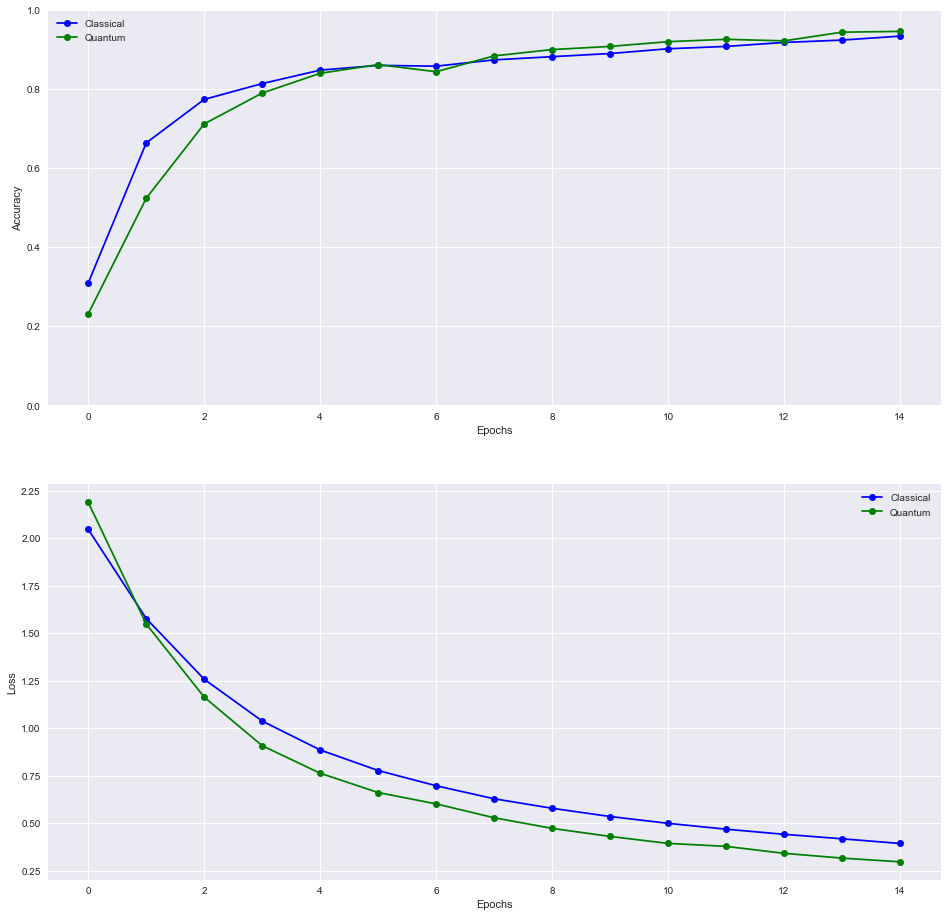

In [160]:
plt.style.use(style='seaborn')
figure, (axes1, axes2) = plt.subplots(nrows=2, ncols=1, figsize=(16, 16))

# on first subplot, plot the accuracy of the two models.
axes1.plot(chistory.history['accuracy'], 'b-o', label='Classical') # plot using (b)lue 'o's. similarly 'r+' plots red plusses. The - is to connect all resulting points in the plot.
axes1.plot(qhistory.history['accuracy'], 'g-o', label='Quantum')
axes1.set_ylabel('Accuracy')
axes1.set_xlabel('Epochs')
axes1.set_ylim([0, 1])
axes1.legend()

# id to above, ony change: Accuracy -> Loss. Plotted on second subplot.
axes2.plot(chistory.history['loss'], 'b-o', label='Classical') # plot using (b)lue 'o's. similarly 'r+' plots red plusses. The - is to connect all resulting points in the plot.
axes2.plot(qhistory.history['loss'], 'g-o', label='Quantum')
axes2.set_ylabel('Loss')
axes2.set_xlabel('Epochs')
axes2.legend()